# MaskGIT Demo

## Clone Repository

## Download Pretrained models

In [1]:
# from huggingface_hub import hf_hub_download

# hf_hub_download(repo_id="llvictorll/Maskgit-pytorch", filename="pretrained_maskgit/VQGAN/last.ckpt", local_dir=".")
# hf_hub_download(repo_id="llvictorll/Maskgit-pytorch", filename="pretrained_maskgit/VQGAN/model.yaml", local_dir=".")
# hf_hub_download(repo_id="llvictorll/Maskgit-pytorch", filename="pretrained_maskgit/MaskGIT/MaskGIT_ImageNet_256.pth", local_dir=".")
# hf_hub_download(repo_id="llvictorll/Maskgit-pytorch", filename="pretrained_maskgit/MaskGIT/MaskGIT_ImageNet_512.pth", local_dir=".")

In [11]:
import os
import time
import random
import math
import seaborn as sns

import numpy as np
import argparse

import torch
import torch.nn.functional as F
import torchvision.utils as vutils
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt

from Trainer.vit import MaskGIT

# MaskGIT initialisation

In [33]:
class Args(argparse.Namespace):
    # data_folder="/Datasets/CIFAR10/"                          
    vit_folder="./pretrained_maskgit/MaskGIT/MaskGIT_ImageNet_256.pth"
    vqgan_folder="./pretrained_maskgit/VQGAN/"
    writer_log=""
    data = "imagenet"
    mask_value = 1024                                                            # Value of the masked token
    img_size = 256                                                               # Size of the image
    path_size = img_size // 16                                                   # Number of vizual token
    seed = 1                                                                     # Seed for reproducibility
    channel = 3                                                                  # Number of input channel
    num_workers = 4                                                              # Number of workers
    iter = 1_500_000                                                             # 750_000 at 256*256 + 750_000 at 512*512
    global_epoch = 380                                                           # 300 epoch w/ bsize 512 + 80 epoch with bsize 128
    lr = 1e-4                                                                    # Learning rate 
    drop_label = 0.1                                                             # Drop out label for cfg
    resume = True                                                                # Set to True for loading model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")        # Device
    print(device)
    debug = True                                                                 # Load only the model (not the dataloader)
    test_only = False                                                            # Dont launch the testing
    is_master = True                                                             # Master machine 
    is_multi_gpus = False                                                        # set to False for colab demo

args=Args()

# Fixe seed
if args.seed > 0:
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    np.random.seed(args.seed)
    random.seed(args.seed)
    torch.backends.cudnn.enable = False
    torch.backends.cudnn.deterministic = True

# Instantiate the MaskGIT
maskgit = MaskGIT(args)

cuda
load ckpt from: ./pretrained_maskgit/MaskGIT/MaskGIT_ImageNet_256.pth
Size of model vit: 174.161M
Size of model autoencoder: 72.142M


In [34]:
def viz(x, nrow=10, pad=2, size=(18, 18)):
    """
    Visualize a grid of images.

    Args:
        x (torch.Tensor): Input images to visualize.
        nrow (int): Number of images in each row of the grid.
        pad (int): Padding between the images in the grid.
        size (tuple): Size of the visualization figure.

    """
    nb_img = len(x)
    min_norm = x.min(-1)[0].min(-1)[0].min(-1)[0].view(-1, 1, 1, 1)
    max_norm = x.max(-1)[0].max(-1)[0].max(-1)[0].view(-1, 1, 1, 1)
    x = (x - min_norm) / (max_norm - min_norm)

    x = vutils.make_grid(x.float().cpu(), nrow=nrow, padding=pad, normalize=False)
    plt.figure(figsize = size)
    plt.axis('off')
    plt.imshow(x.permute(1, 2, 0))
    plt.savefig(f'./saved_img/256_256/{time.strftime("%y%m%d_%H%M%S",time.localtime())}.png')
    plt.show()
    

def decoding_viz(gen_code, mask, maskgit):
    """
    Visualize the decoding process of generated images with associated masks.

    Args:
        gen_code (torch.Tensor): Generated code for decoding.
        mask (torch.Tensor): Mask used for decoding.
        maskgit (MaskGIT): MaskGIT instance.
    """
    start = torch.FloatTensor([1, 1, 1]).view(1, 3, 1, 1).expand(1, 3, maskgit.patch_size, maskgit.patch_size) * 0.8
    end = torch.FloatTensor([0.01953125, 0.30078125, 0.08203125]).view(1, 3, 1, 1).expand(1, 3, maskgit.patch_size, maskgit.patch_size) * 1.4
    code = torch.stack((gen_code), dim=0).squeeze()
    mask = torch.stack((mask), dim=0).view(-1, 1, maskgit.patch_size, maskgit.patch_size).cpu()

    with torch.no_grad():
        x = maskgit.ae.decode_code(torch.clamp(code, 0, 1023))

    binary_mask = mask * start + (1 - mask) * end
    binary_mask = vutils.make_grid(binary_mask, nrow=len(gen_code), padding=1, pad_value=0.4, normalize=False)
    binary_mask = binary_mask.permute(1, 2, 0)

    plt.figure(figsize = (18, 2))
    plt.gca().invert_yaxis()
    plt.pcolormesh(binary_mask, edgecolors='w', linewidth=.5)
    plt.axis('off')
    plt.show()

    viz(x, nrow=len(gen_code))

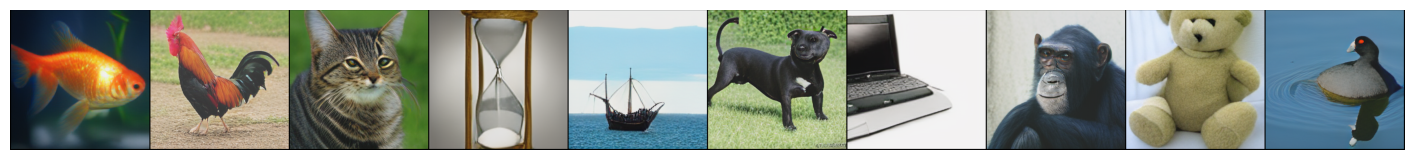

In [35]:
sm_temp = 1.3          # Softmax Temperature
r_temp = 7             # Gumbel Temperature
w = 9                  # Classifier Free Guidance
randomize = "linear"   # Noise scheduler
step = 32              # Number of step
sched_mode = "arccos"  # Mode of the scheduler

labels, name = [1, 7, 282, 604, 724, 179, 681, 367, 850, random.randint(0, 999)] * 1, "r_row"
labels = torch.LongTensor(labels).to(args.device)
# Generate sample
gen_sample, gen_code, l_mask = maskgit.sample(nb_sample=labels.size(0), labels=labels, sm_temp=sm_temp, w=w, randomize=randomize, r_temp=r_temp, sched_mode=sched_mode, step=step)

viz(gen_sample, nrow=10, size=(18, 18))

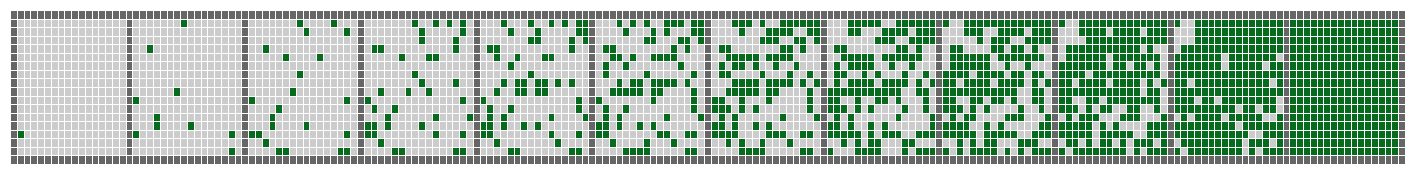

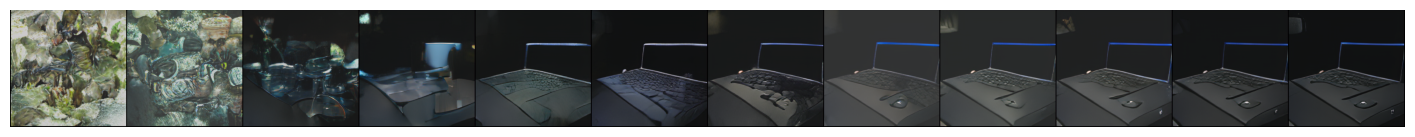

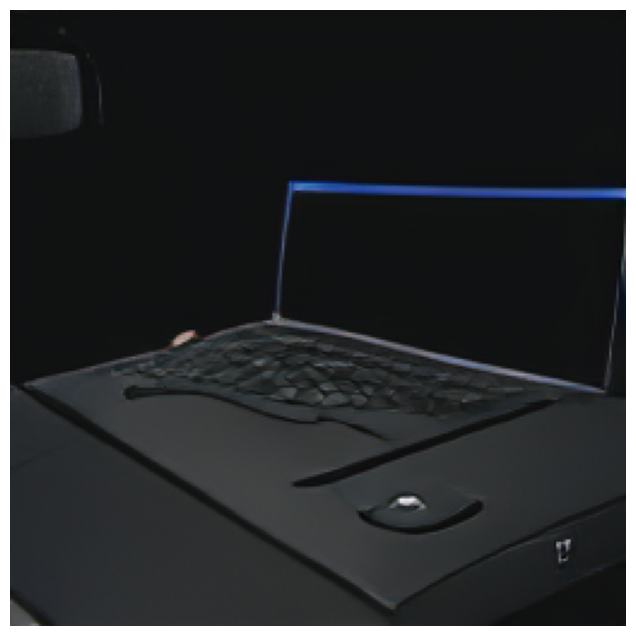

In [45]:
labels, name = 681, "cat"
sample, code, mask = maskgit.sample(nb_sample=1, labels=torch.LongTensor([labels]).to(args.device), sm_temp=1.3, w=9, randomize="linear", r_temp=4.5, sched_mode="arccos", step=12)
decoding_viz(code, mask, maskgit=maskgit)
viz(sample, size=(8,8))